Imports the Firedrake library to initialize the simulation environment:

In [1]:
import firedrake

ModuleNotFoundError: No module named 'firedrake'

In addition to importing firedrake as usual, we will need to construct the correct quadrature rules for the mass-lumping by hand. FInAT is responsible for providing these quadrature rules, so we import it here too.:

In [ ]:
from firedrake import *
import finat

import math

A simple uniform triangular mesh is created:

In [ ]:
mesh = RectangleMesh(100, 100, 5.0, 5.0)

We choose a degree 2 KMV continuous function space, set it up and then create some functions used in time-stepping:

In [ ]:
V = FunctionSpace(mesh, "KMV", 2)

u = TrialFunction(V)
v = TestFunction(V)

u_np1 = Function(V)  # timestep n+1
u_n = Function(V)    # timestep n
u_nm1 = Function(V)  # timestep n-1

Now we set the time-stepping variables performing a simulation for 1 second with a timestep of 0.001 seconds:

In [ ]:
T = 1.0
dt = 0.001
t = 0
step = 0

Defines the local output path, creates the necessary directories, and initializes the file writer:

In [ ]:
import os
from firedrake import VTKFile

root = "." 
outdir = os.path.join(root, "outputs", "scalar_wave_equation_larger_domain-out")
os.makedirs(outdir, exist_ok=True)
vtk = VTKFile(os.path.join(outdir, "scalar_wave_equation_larger_domain.pvd"))

Ricker wavelets are often used to excite the domain in seismology. They have one free parameter: a peak frequency peak.
.

Here we inject a Ricker wavelet into the domain with a frequency of 6 Hz. For simplicity, we set the seismic velocity in the domain to be a constant:

In [ ]:
freq = 6
c = Constant(1.5)

The following two functions are used to inject the Ricker wavelet source into the domain. We create a time-varying function to model the time evolution of the Ricker wavelet, given by the equation below and illustrated in Figure 1:

$f(t) = [1 - 2 (\pi f_p t)^2] e^{-(\pi f_p t)^2}$


**Figure 1 - Ricker Wavelet**
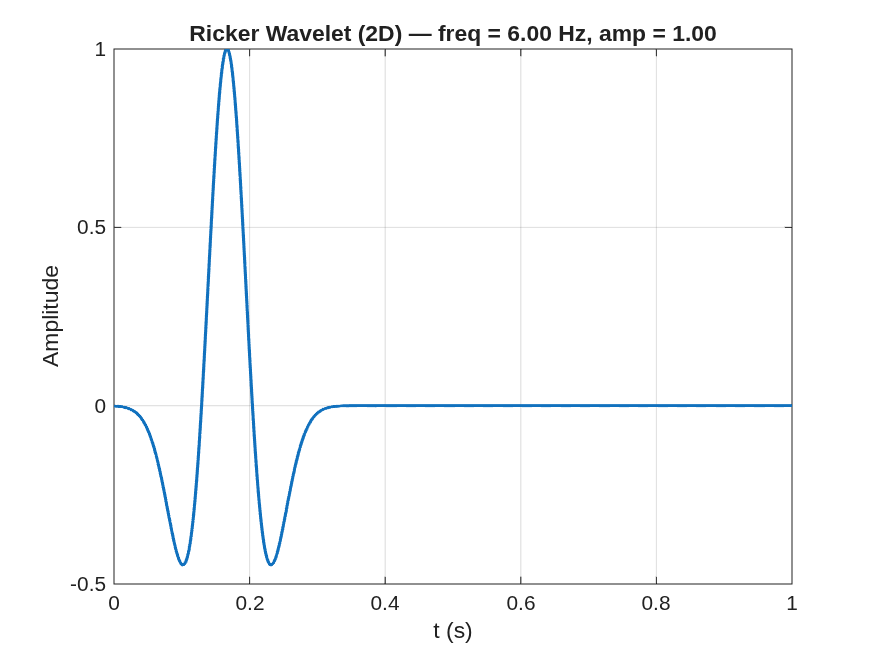

In [ ]:
def RickerWavelet(t, freq, amp=1.0):
    # Shift in time so the entire wavelet is injected
    t_shifted = t - 1.0 / freq  # Time shift to center the wavelet

    factor = 1 - 2 * math.pi**2 * (freq**2) * (t_shifted**2)
    envelope = math.exp(-math.pi**2 * (freq**2) * (t_shifted**2))

    return amp * factor * envelope

The spatial distribution of the source function is a Guassian kernel with a standard deviation of 2,000 so that it’s sufficiently localized to emulate a Dirac delta function:

In [ ]:
def delta_expr(x0, x, y, sigma_x=2000.0):
    sigma_x = Constant(sigma_x)
    return exp(-sigma_x * ((x - x0[0]) ** 2 + (y - x0[1]) ** 2))

To assemble the diagonal mass matrix, we need to create the matching colocated quadrature rule. FInAT implements custom "KMV" quadrature rules to do this. We obtain the appropriate cell from the function space, along with the degree of the element and construct the quadrature rule:

In [ ]:
quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")

Then we make a new Measure object that uses this rule:

In [ ]:
dxlump=dx(scheme=quad_rule)

Using Firedrake, we specify the mass matrix using the special quadrature rule with the Measure object we created above like so:

In [ ]:
m = (u - 2.0 * u_n + u_nm1) / Constant(dt * dt) * v * dxlump

The stiffness matrix $a(u,v)$ is formed using a standard quadrature rule and is treated explicitly:

In [ ]:
a = c*c*dot(grad(u_n), grad(v)) * dx

The source is injected at the center of the unit square:

In [ ]:
x, y = SpatialCoordinate(mesh)
source = Constant([2.5, 4.5])
ricker = Constant(0.0)
ricker.assign(RickerWavelet(t, freq))

We also create a cofunction R to save the assembled RHS vector:

In [ ]:
R = Cofunction(V.dual())

Finally, we define the whole variational form $F$, assemble it, and then create a cached PETSc LinearSolver object to efficiently timestep with:

In [ ]:
F = m + a -  delta_expr(source, x, y)*ricker * v * dx
a, r = lhs(F), rhs(F)
A = assemble(a)
solver = LinearSolver(A, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})

Now we are ready to start the time-stepping loop:

In [ ]:
step = 0
while t < T:
    step += 1
    ricker.assign(RickerWavelet(t, freq))
    R = assemble(r, tensor=R)
    solver.solve(u_np1, R)
    u_nm1.assign(u_n)
    u_n.assign(u_np1)
    t += dt
    if step % 10 == 0:
        print("Elapsed time is: "+str(t))
        outfile.write(u_n, time=t)